<a href="https://colab.research.google.com/github/bjkone/AI/blob/main/deforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSMVAnvupEsD8ydEgnFeuWK3SiIIEgBGQ42a5Ov8zbyM01a-OgC&s)

## Planet: Understanding the Amazon deforestation from Space challenge

Every minute, the world loses an area of forest the size of 48 football fields. And deforestation in the Amazon Basin accounts for the largest share, contributing to reduced biodiversity, habitat loss, climate change, and other devastating effects. But better data about the location of deforestation and human encroachment on forests can help governments and local stakeholders respond more quickly and effectively.

Planet, designer and builder of the world’s largest constellation of Earth-imaging satellites, will soon be collecting daily imagery of the entire land surface of the earth at 3-5 meter resolution. While considerable research has been devoted to tracking changes in forests, it typically depends on coarse-resolution imagery from Landsat (30 meter pixels) or MODIS (250 meter pixels). This limits its effectiveness in areas where small-scale deforestation or forest degradation dominate

Import required Python libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import seaborn as sns
import matplotlib.image as mpimg

x_train = []
x_test = []
y_train = []

## Data preparation

In [3]:
!pip install kaggle

In [6]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [7]:
!kaggle datasets download -d nikitarom/planets-dataset

100% 1.50G/1.50G [01:11<00:00, 25.9MB/s]
100% 1.50G/1.50G [01:11<00:00, 22.5MB/s]


In [8]:
!unzip planets-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: test-jpg-additional/test-jpg-additional/file_5499.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_55.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_550.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5500.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5501.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5502.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5503.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5504.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5505.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5506.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5507.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5508.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5509.jpg  
  inflating: test-jpg-additional/test-jpg-additional/fi

In [ ]:
#!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.92 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/6322/868312/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1587650394&Signature=loPoXxoihVe2WVZ0ZI9QW1aA5PZjK7jkXxKRr%2FjdqqYe6vJM1M6B1YgApDlUs1BmSHqRhGi9K9OvnoLdiI7lpfui1KuFmVkwvmeYxyCCI65CC5sLkcJQnO%2BF5yqiq2rWkAG9kAm8cT9Z3c2Woq1fbi013SjlASlADVSdlrWsfyGgTygjUfPIvy5agRXcJcEuGAO8BwrRvdWzQw0KZ3I9pItlpY2ASlAtRGdiNXG3JsLT6%2BGlKXA4k1eaNpd0skck8E%2FZ0%2BBs1Pfw2wvoNSoayDY5RlBjNrIAVxuaGF20HcCev9uLA9RviaNnYGnoUc%2Fwn7Wbs2cIF8BFyvssY9qAkg%3D%3D&response-content-disposition=attachment%3B+filename%3Dplanet-understanding-the-amazon-from-space.zip" -c -O 'planet-understanding-the-amazon-from-space.zip'

In [9]:
!pwd
!ls /content/planet/planet/

/content
sample_submission.csv  test-jpg  train_classes.csv  train-jpg


In [10]:
import os
print(os.getcwd())
os.chdir('/content/planet/planet')
print(os.getcwd())

/content
/content/planet/planet


In [ ]:
#!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/6322/868312/upload/train-jpg.tar.7z?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1587567206&Signature=azVDwSxO8G6WgPUC0bjs7s70rTHVNyqTVr%2Bf2pnDXzFMUe0cEQlxgOrdF7Nl9USwXQQzk39TA%2F8By3c9FYg62UwGge5XubH227K636lzP7uwLP41ZTa9hNMBtVyvNkT32wtp%2BrcwWngEkpiNyoKigD3saaH9ZzwM%2BsVVbwvOpzwqXR7MgtujIysv4ZQb4M4GdqX4YvmIvEjs4kz%2FYAXsGi2PbPwjqnWp1nY%2F5IU45mwt1TGdTeMvgxO7Jwdg0CLAuYK4TbwpKB94TuKgNeD4XzXJg%2Fy12n1UM5h2VlNwR687ayoxQ6MLevLyNDEFQP8tsq3QooDmmQWZQLGKkO69FA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain-jpg.tar.7z" -c -O 'train-jpg.tar.7z'

In [ ]:
#!7z x -so train-jpg.tar.7z | tar xf -

## Inspect image labels


In [11]:
df_train_images = pd.read_csv('train_classes.csv')
print(df_train_images)

        image_name                                           tags
0          train_0                                   haze primary
1          train_1                agriculture clear primary water
2          train_2                                  clear primary
3          train_3                                  clear primary
4          train_4      agriculture clear habitation primary road
...            ...                                            ...
40474  train_40474                                  clear primary
40475  train_40475                                         cloudy
40476  train_40476                      agriculture clear primary
40477  train_40477                 agriculture clear primary road
40478  train_40478  agriculture cultivation partly_cloudy primary

[40479 rows x 2 columns]


In [12]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in df_train_images['tags'].values]))
print(labels_list)
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

['haze', 'primary', 'agriculture', 'clear', 'primary', 'water', 'clear', 'primary', 'clear', 'primary', 'agriculture', 'clear', 'habitation', 'primary', 'road', 'haze', 'primary', 'water', 'agriculture', 'clear', 'cultivation', 'primary', 'water', 'haze', 'primary', 'agriculture', 'clear', 'cultivation', 'primary', 'agriculture', 'clear', 'cultivation', 'primary', 'road', 'agriculture', 'clear', 'primary', 'slash_burn', 'water', 'clear', 'primary', 'water', 'cloudy', 'clear', 'primary', 'cloudy', 'clear', 'primary', 'clear', 'primary', 'partly_cloudy', 'primary', 'clear', 'primary', 'agriculture', 'clear', 'primary', 'road', 'agriculture', 'clear', 'primary', 'water', 'clear', 'primary', 'road', 'water', 'partly_cloudy', 'primary', 'agriculture', 'clear', 'primary', 'road', 'conventional_mine', 'partly_cloudy', 'primary', 'clear', 'primary', 'cloudy', 'agriculture', 'partly_cloudy', 'primary', 'water', 'clear', 'primary', 'partly_cloudy', 'primary', 'clear', 'primary', 'water', 'clear'

## Repartition of each labels

primary              37513
clear                28431
agriculture          12315
road                  8071
water                 7411
partly_cloudy         7261
cultivation           4547
habitation            3660
haze                  2697
cloudy                2089
bare_ground            862
selective_logging      340
artisinal_mine         339
blooming               332
slash_burn             209
blow_down              101
conventional_mine      100
dtype: int64


<Axes: >

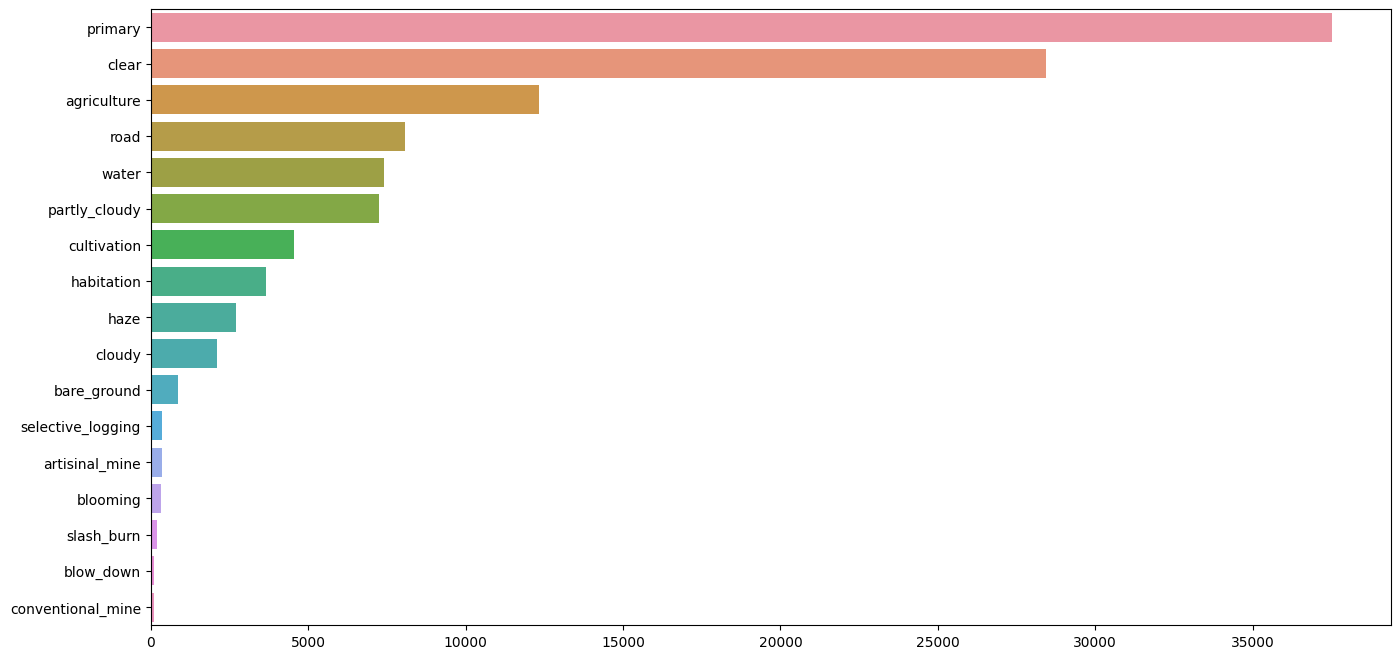

In [13]:
# Histogram of label instances
import matplotlib.pyplot as plt
import seaborn as sns
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
print(labels_s)
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

## Images

Visualize some chip images to know what we are dealing with. Lets vizualise 1 chip for the 17 images to get a sense of their differences.

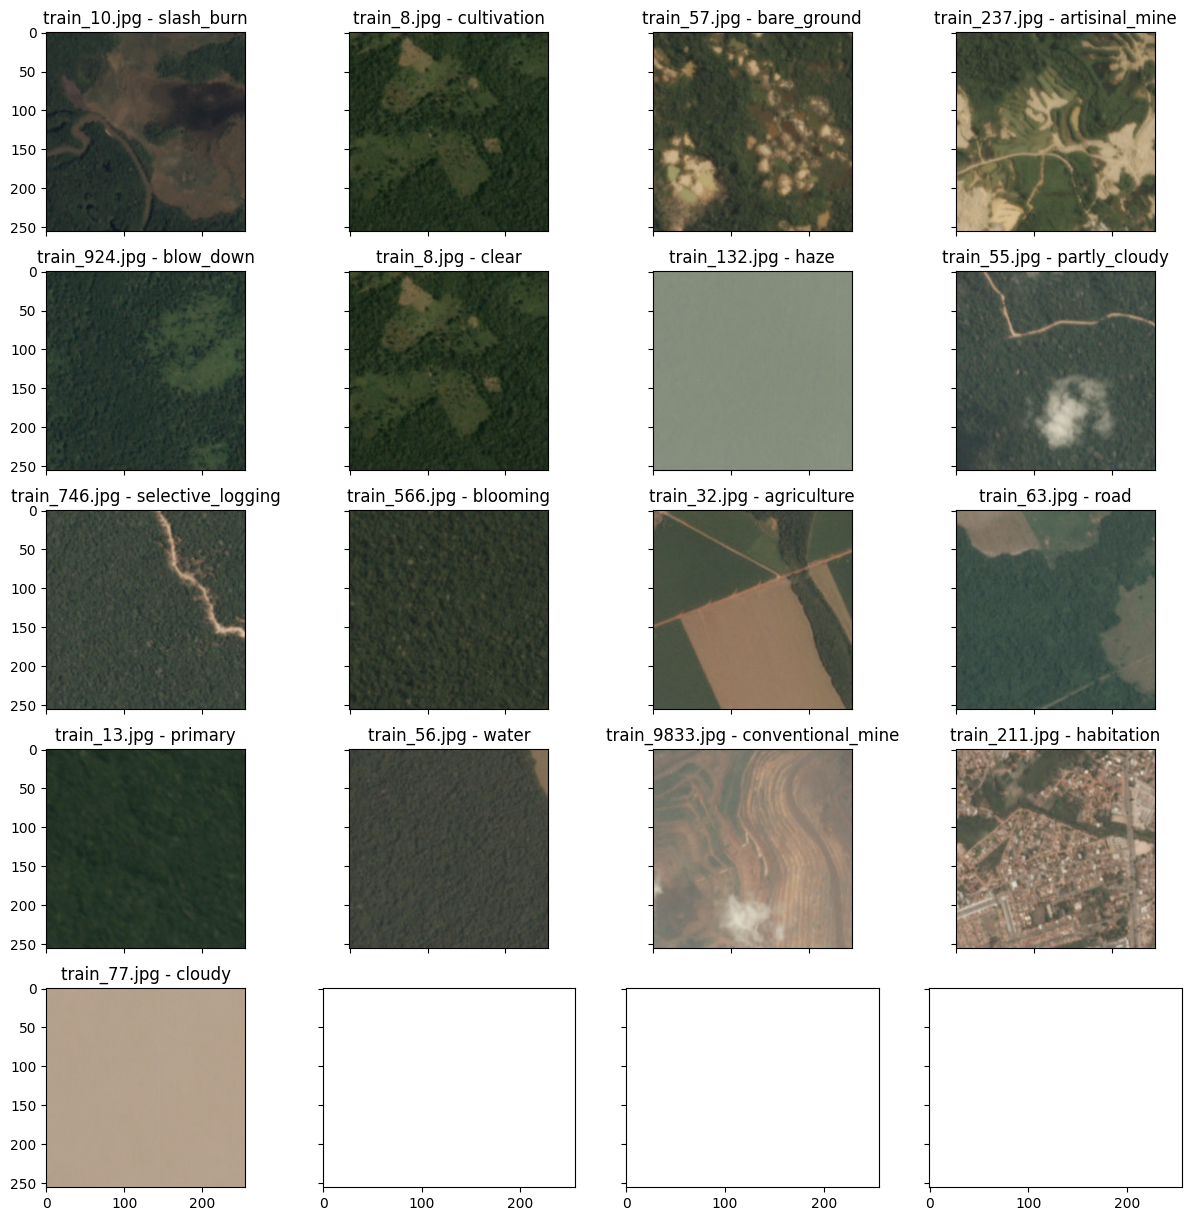

In [14]:
train_jpeg_dir = 'train-jpg'
images_title_set = [df_train_images[df_train_images['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg'
                for i, label in enumerate(labels_set)]

plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 15))
axs = axs.ravel()


for i, (image_name, label) in enumerate(zip(images_title_set, labels_set)):
    img = mpimg.imread(train_jpeg_dir + '/' + image_name)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))

## Image resize, Data preprocessing & validation split

Define the dimensions of the image data trained by the network. Recommended resized images could be 32x32, 64x64, or 128x128 to speedup the training.

You could also use None to use full sized images.

Be careful, the higher the validation_split_size the more RAM you will consume.


##Data preprocessing

Due to the hudge amount of memory the preprocessed images can take, we will normalize image pixel values between 0 and 1 so that our RAM don't get completely filled by the preprocessed images.

In [15]:
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train_images['tags'].values])))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

In [16]:
for f, tags in tqdm(df_train_images.values, miniters=1000):
    img = cv2.imread('train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    x_train.append(cv2.resize(img, (32, 32)))
    y_train.append(targets)

100%|██████████| 40479/40479 [00:58<00:00, 686.68it/s]


In [17]:
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.

print(x_train.shape)
print(y_train.shape)

(40479, 32, 32, 3)
(40479, 17)


In [18]:
split = 35000
x_train, x_valid, y_train, y_valid = x_train[:split], x_train[split:], y_train[:split], y_train[split:]

## Model Building Convolutional Neural Network

---



![alt text](https://miro.medium.com/max/1400/0*-1Pad7loK_dFOUvS.png)


In [19]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(32, 32, 3)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
              optimizer='adam',
              metrics=['accuracy'])

## Include callbacks and save model for future use

## Callbacks
A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training. You can pass a list of callbacks (as the keyword argument callbacks) to the .fit() method of the Sequential or Model classes. The relevant methods of the callbacks will then be called at each stage of the training.

In [20]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-lung.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [23]:
Model_Run = model.fit(x_train, y_train, batch_size=128, epochs=7, callbacks=callbacks, \
                    validation_data=(x_valid, y_valid))

Epoch 1/7
274/274 [==============================] - ETA: 0s - loss: 0.1743 - accuracy: 0.0890
Epoch 1: val_loss improved from 0.16559 to 0.16185, saving model to model-lung.h5
274/274 [==============================] - 113s 414ms/step - loss: 0.1743 - accuracy: 0.0890 - val_loss: 0.1618 - val_accuracy: 0.0507 - lr: 0.0010
Epoch 2/7
274/274 [==============================] - ETA: 0s - loss: 0.1703 - accuracy: 0.1075
Epoch 2: val_loss improved from 0.16185 to 0.15844, saving model to model-lung.h5
274/274 [==============================] - 115s 422ms/step - loss: 0.1703 - accuracy: 0.1075 - val_loss: 0.1584 - val_accuracy: 0.0911 - lr: 0.0010
Epoch 3/7
274/274 [==============================] - ETA: 0s - loss: 0.1668 - accuracy: 0.1174
Epoch 3: val_loss improved from 0.15844 to 0.15489, saving model to model-lung.h5
274/274 [==============================] - 116s 424ms/step - loss: 0.1668 - accuracy: 0.1174 - val_loss: 0.1549 - val_accuracy: 0.0655 - lr: 0.0010
Epoch 4/7
274/274 [======

## Model Evaluation

In [24]:
def plot_Evaluation(history, title):
    plt.figure(figsize=(10,3))
    # Plot training & validation accuracy values
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

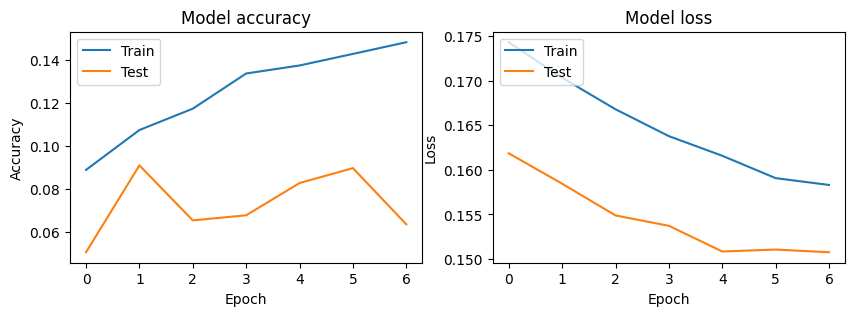

In [25]:
plot_Evaluation(Model_Run, 'Model Loss/Accuracy')

## Calculate Evaluation metric

## Confusion Matrix

A confusion matrix is a summary of prediction results on a classification problem.
The number of correct and incorrect predictions are summarized with count values and broken down by each class. This is the key to the confusion matrix.
#True Positive:
Interpretation: You predicted positive and it’s true.
You predicted that a given image is partly cloudy and it actually is.
#True Negative:
Interpretation: You predicted negative and it’s true.
You predicted that image is not partly cloudy and it actually is not.
#False Positive: (Type 1 Error)
Interpretation: You predicted positive and it’s false.
You predicted that a image is partly cloudy but it is actually not.
#False Negative: (Type 2 Error)
Interpretation: You predicted negative and it’s false.
You predicted that a image is not partly clody but it is actually partly cloudy.
![alt text](https://www.dataschool.io/content/images/2015/01/confusion_matrix2.png)

#Recall
Out of all the positive classes, how much we predicted correctly. It should be high as possible

![alt text](https://miro.medium.com/max/369/1*BT3awaBdZHsit5s41LPb9A.png)

#Precision
Out of all the positive classes we have predicted correctly, how many are actually positive.

![alt text](https://miro.medium.com/max/374/1*QRIZDkk_FffXKs_07ZlhZw.png)

## F score
Harmonic Mean of Recall and Precision

![alt text](https://miro.medium.com/max/716/1*98FaAKfPWo-EBTbjsxm4GA.png)

In [ ]:
from sklearn.metrics import fbeta_score

p_valid = model.predict(x_valid, batch_size=128)
p_Class = model.predict_classes(x_valid, batch_size=128)
print(fbeta_score(y_valid, np.array(p_valid) > 0.2, beta=2, average='samples'))

0.8465304226821035
